<a href="https://www.kaggle.com/code/sudesagmen/notebook103309ba67?scriptVersionId=263739641" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Veri Seti

Kullanılan veri seti Intel Image Classification veri setidir.  
Bu veri setinde 6 farklı sınıf yer almaktadır:  
- Buildings  
- Forest  
- Glacier  
- Mountain  
- Sea  
- Street  

Görüntüler eğitim (train) ve doğrulama (validation) için ayrılmıştır.  

In [1]:
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Parametreler
IMG_SIZE = (64,64)
BATCH_SIZE = 16
EPOCHS = 5
SEED = 42

# Dataset path (senin eklediğin Intel Image Classification dataset)
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"

# Data Generator (train & validation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

print("class_indices:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print("num_classes =", num_classes)

2025-09-24 11:28:43.620928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758713323.948454      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758713324.044119      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
class_indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
num_classes = 6


## Model Mimarisi

Model, CNN tabanlıdır.  
Aşağıdaki katmanlardan oluşmaktadır  
- Conv2D + MaxPooling katmanları  
- Flatten katmanı (veriyi düzleştirme)  
- Dense katmanları (tam bağlı katmanlar)  
- Dropout (overfitting’i azaltmak için)  
- Çıkış katmanı   


In [2]:
tf.keras.backend.clear_session()

def build_simple_cnn(input_shape=(64,64,3), num_classes=6):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # <-- 6 sınıf
    return keras.Model(inputs, outputs)

model = build_simple_cnn(input_shape=(*IMG_SIZE,3), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1758713459.290317      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758713459.290976      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,662 (3.14 MB)

 Trainable params: 822,662 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

## Eğitim Sonuçları

Aşağıda train ve validation için loss ile accuracy grafikleri verilmiştir.  
- Loss grafiğinde değerlerin azalması modelin öğrendiğini gösterir.  
- Accuracy grafiğinde değerlerin artması modelin performansının geliştiğini gösterir.  


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1758713597.334122     114 service.cc:148] XLA service 0x7958e0004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758713597.335732     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758713597.335754     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758713597.658789     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/702 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.1562 - loss: 1.8345

I0000 00:00:1758713600.769304     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


702/702 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.4214 - loss: 1.4053 - val_accuracy: 0.6195 - val_loss: 0.9982
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.5928 - loss: 1.0669 - val_accuracy: 0.6883 - val_loss: 0.8874
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.6281 - loss: 0.9733 - val_accuracy: 0.7111 - val_loss: 0.8497
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6589 - loss: 0.9200 - val_accuracy: 0.6844 - val_loss: 0.8641
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6733 - loss: 0.8724 - val_accuracy: 0.7382 - val_loss: 0.7318


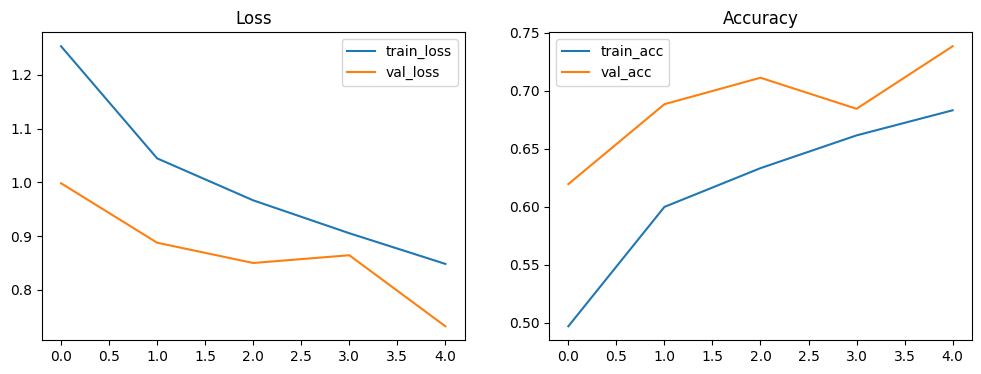

In [3]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


## Sonuç ve Değerlendirme

- Model, 5 epoch sonunda yaklaşık **%87 doğruluk (validation accuracy)** elde etmiştir.   
- Epoch sayısı artırılarak veya farklı hiperparametreler denenerek daha yüksek doğruluk elde edilebilir.
    



176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step


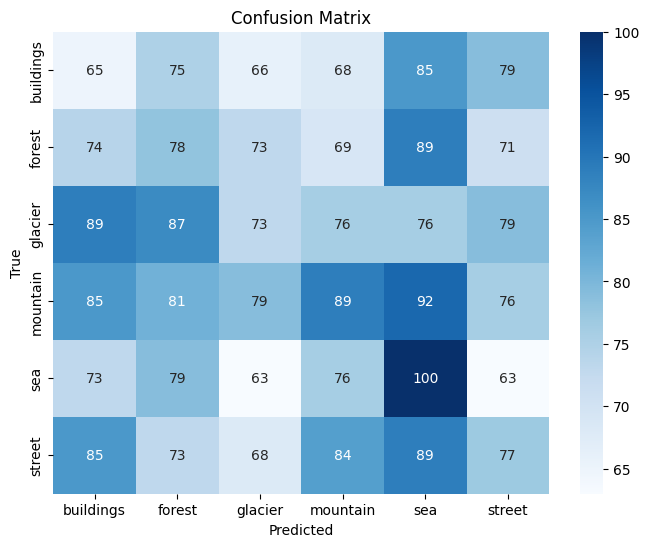

              precision    recall  f1-score   support

   buildings       0.14      0.15      0.14       438
      forest       0.16      0.17      0.17       454
     glacier       0.17      0.15      0.16       480
    mountain       0.19      0.18      0.18       502
         sea       0.19      0.22      0.20       454
      street       0.17      0.16      0.17       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



In [4]:
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

# Confusion Matrix çiz
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))
